In [48]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().resolve().parent.parent))

In [49]:
# experiments
from experiments.run_sweep import run_sweep
from experiments.run_experiment import TrainingConfig, EvaluateConfig
from experiments.sweep_plots import plot_sweep_training, plot_sweep_evaluation
from experiments.sweep_plots_helpper import frozenlake_training_plot_specs, frozenlake_evaluation_plot_specs

# environments
from environments.fronzenlake import FrozenLakeConfig, get_frozenlake_env

# SARSA confirmation bias agent
from agents.sarsa_td0_confirmation_bias import (
    SarsaTD0ConfirmationBiasConfig,
    SarsaTD0ConfirmationBiasAgent,
)

# metrics for training
from metrics.reward_mertrics import frozenlake_reward_metrics_specs
from metrics.frustration_metrics import frustration_metrics_specs

# external libraries
import numpy as np

In [50]:
BASE_AGENT_CONFIG_CONF = dict(
    alpha_conf=0.2,
    alpha_disconf=0.2,
    gamma=0.99,
    epsilon=0.2,
    reward_metrics=frozenlake_reward_metrics_specs(),
    td_error_metrics=frustration_metrics_specs(),
)


BASE_AGENT_CONFIG_POSITITY = dict(
    alpha_positive=0.2,
    alpha_negative=0.2,
    gamma=0.99,
    epsilon=0.2,
    reward_metrics=frozenlake_reward_metrics_specs(),
    td_error_metrics=frustration_metrics_specs(),
)

## Environments

In [51]:
env_config = FrozenLakeConfig()

## Agents

In [53]:
## Agents
# sarsa_td0 confirmation bias agent
agent_factory = SarsaTD0ConfirmationBiasAgent

sarsa_td0_config = SarsaTD0ConfirmationBiasConfig(**BASE_AGENT_CONFIG_CONF)

## Sweep configuration

In [54]:
base_train = TrainingConfig(
    name="FrozenLake_sarsa_td0",
    num_train_episodes=30000,
    env_kwargs={"config": env_config},
    agent_kwargs={"config": sarsa_td0_config},
)

base_eval = EvaluateConfig(
    name="FrozenLake_sarsa_td0",
    num_eval_episodes=5000,  # use >0 if you want eval outputs
    env_kwargs={"config": env_config},
    evaluation_metrics=frozenlake_reward_metrics_specs(),
)

## Confirmation bias results

In [55]:
def generate_alpha_pairs(
    balanced_lr: float | list[float], num_pairs: int, step_size: float
):
    lrs = balanced_lr if isinstance(balanced_lr, list) else [balanced_lr]

    all_confirmatory_pairs = []
    all_balanced_pairs = []
    all_disconfirmatory_pairs = []

    for lr in lrs:
        confirmatory_pairs = [
            (round(lr + k * step_size, 3), round(lr - k * step_size, 3))
            for k in range(1, num_pairs + 1)
        ]
        balanced_pairs = [(round(lr, 3), round(lr, 3))]
        disconfirmatory_pairs = [
            (round(lr - k * step_size, 3), round(lr + k * step_size, 3))
            for k in range(1, num_pairs + 1)
        ]

        # Highest confirmatory lr first
        confirmatory_pairs.sort(key=lambda p: p[0], reverse=True)

        all_confirmatory_pairs.extend(confirmatory_pairs)
        all_balanced_pairs.extend(balanced_pairs)
        all_disconfirmatory_pairs.extend(disconfirmatory_pairs)

    return all_confirmatory_pairs, all_balanced_pairs, all_disconfirmatory_pairs

In [56]:
# different q_tables
env = get_frozenlake_env(env_config)

In [ ]:
# create different initial q_tables for the sweep
num_states = env.observation_space.n
num_actions = env.action_space.n

# q table initializations
q0 = np.zeros((num_states, num_actions), dtype=np.float64)
q_pos = np.ones((num_states, num_actions), dtype=np.float64)
q_neg = np.ones((num_states, num_actions), dtype=np.float64) * -1

q_tables = [("zeros", q0), ("positive", q_pos), ("negative", q_neg)]

confirmatory_pairs, balanced_pairs, disconfirmatory_pairs = generate_alpha_pairs(
    balanced_lr=[0.2], num_pairs=5, step_size=0.025
)

alpha_pairs = confirmatory_pairs + balanced_pairs + disconfirmatory_pairs
seeds = list(range(15))  # 20 different seeds

sweep = {
    "agent_kwargs": [
        {
            "alpha_conf": a_conf,
            "alpha_disconf": a_disconf,
            "seed": seed,
            "initial_q_table": q_table,
            "initial_q_table_label": label,
        }
        for (a_conf, a_disconf) in alpha_pairs
        for (label, q_table) in q_tables
        for seed in seeds
    ],
}

In [58]:
results = run_sweep(
    base_training=base_train,
    base_evaluation=base_eval,
    sweep=sweep,
    env_factory=get_frozenlake_env,
    agent_factory=agent_factory,
)


In [59]:
len(results)

1

In [104]:
from pathlib import Path
import pickle

out = Path("outputs/sweeps")
out.mkdir(parents=True, exist_ok=True)

file_path = out / "frozenlake_17_3_conf.pkl"
with open(file_path, "wb") as f:
    pickle.dump(results, f)

print(f"Saved to {file_path}")

Saved to outputs/sweeps/frozenlake_17_3_conf.pkl


In [ ]:
# Filter sweep results for runs with initial_q_table_label == "zeros"
zeros_results = [
    r
    for r in results
    if (r.get("params", {}).get("agent_kwargs", {}) or {}).get("initial_q_table_label")
    == "zeros"
]



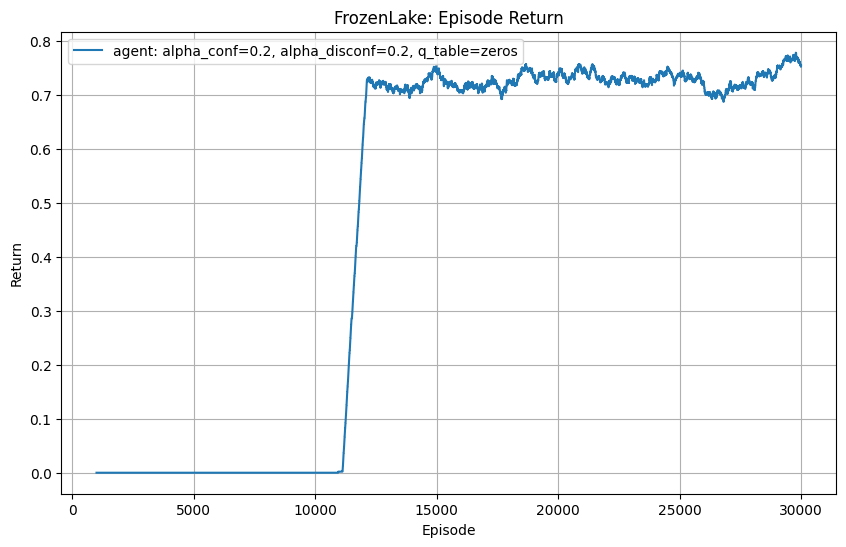

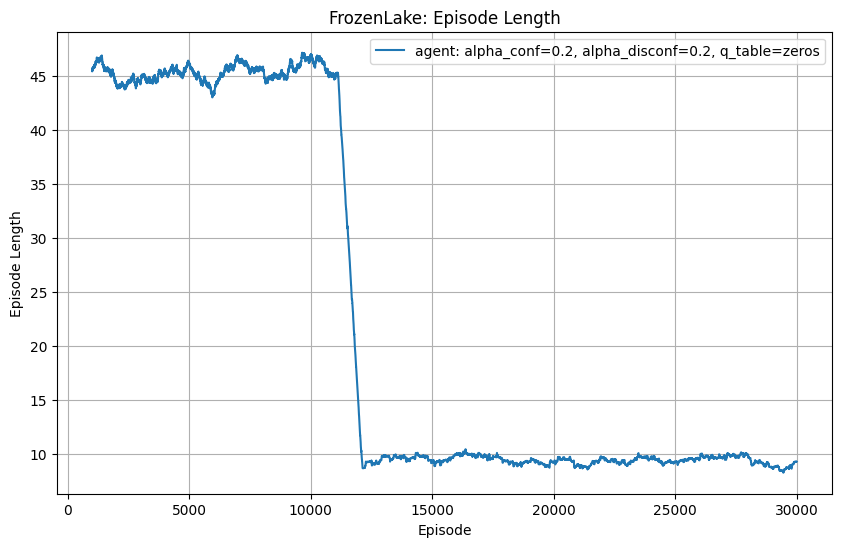

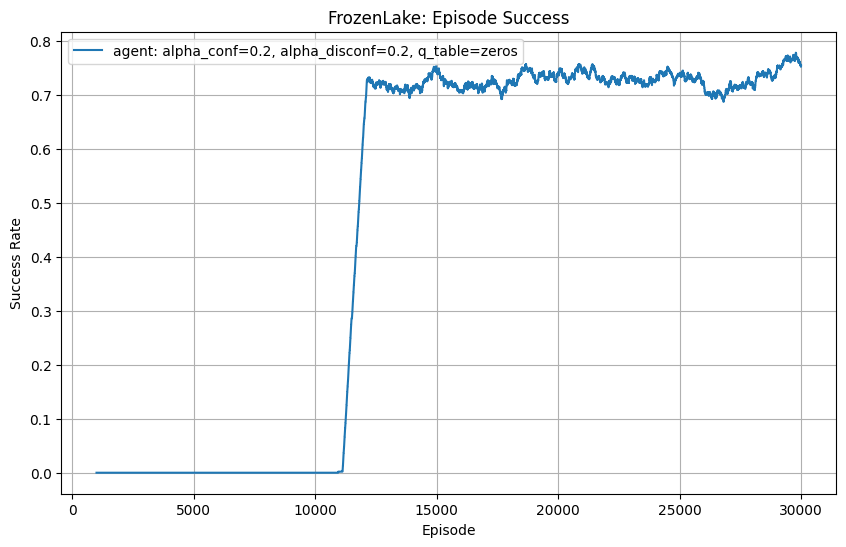

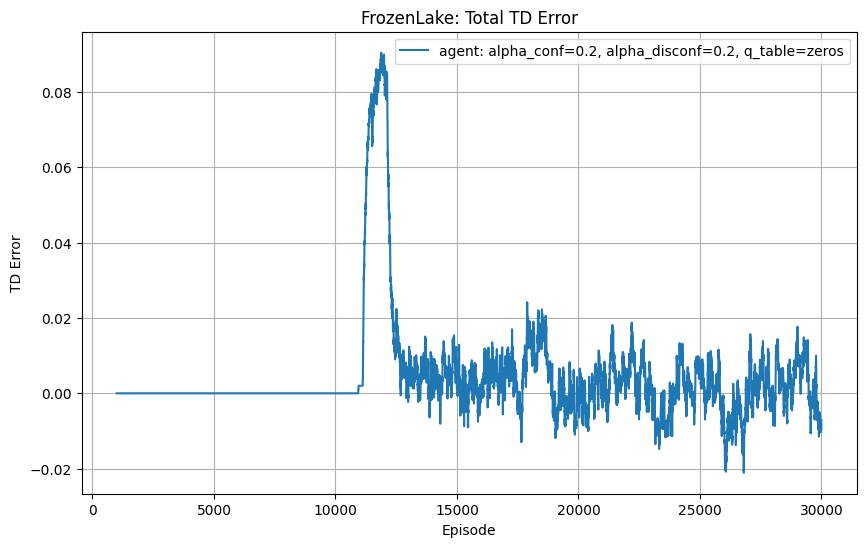

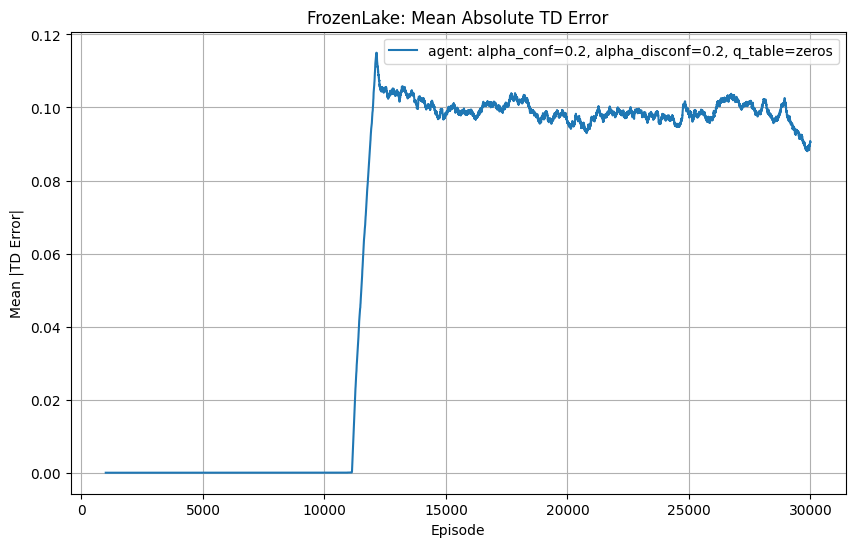

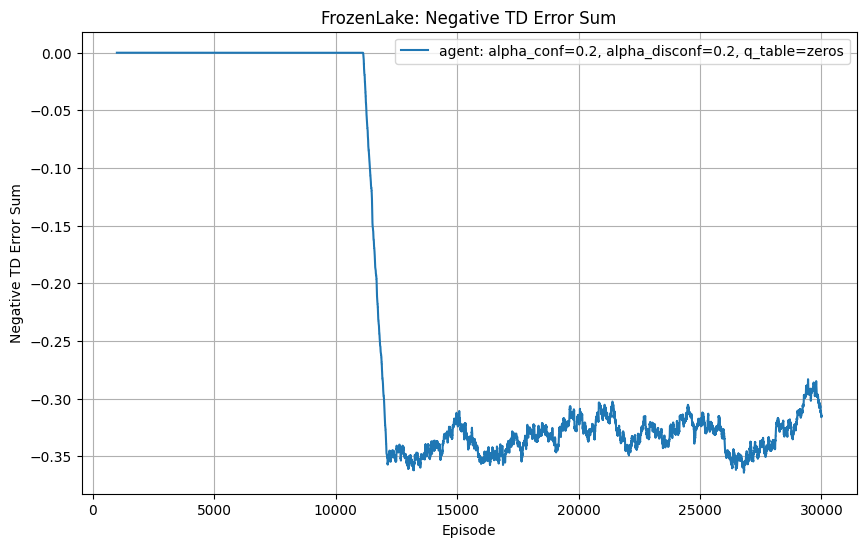

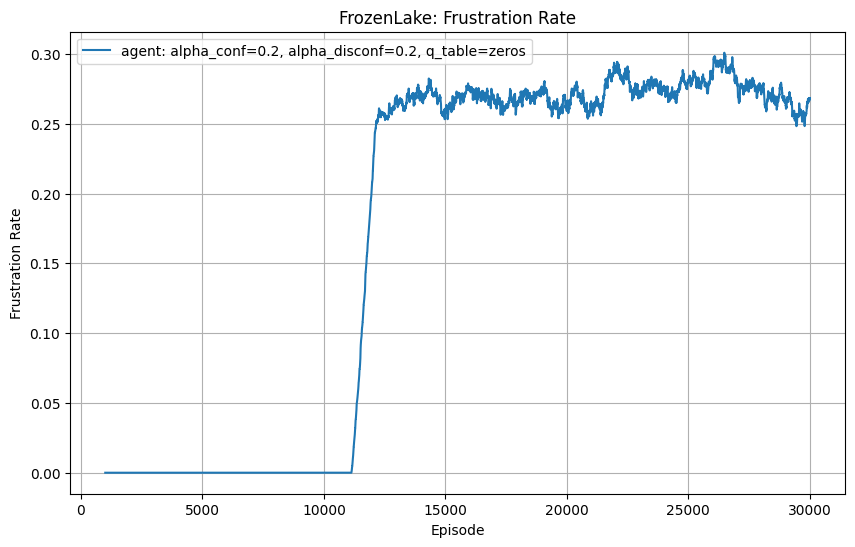

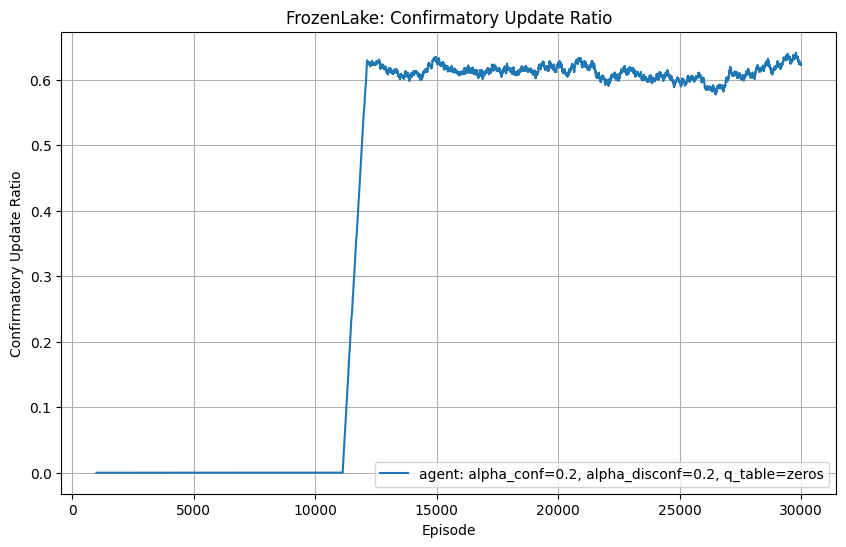

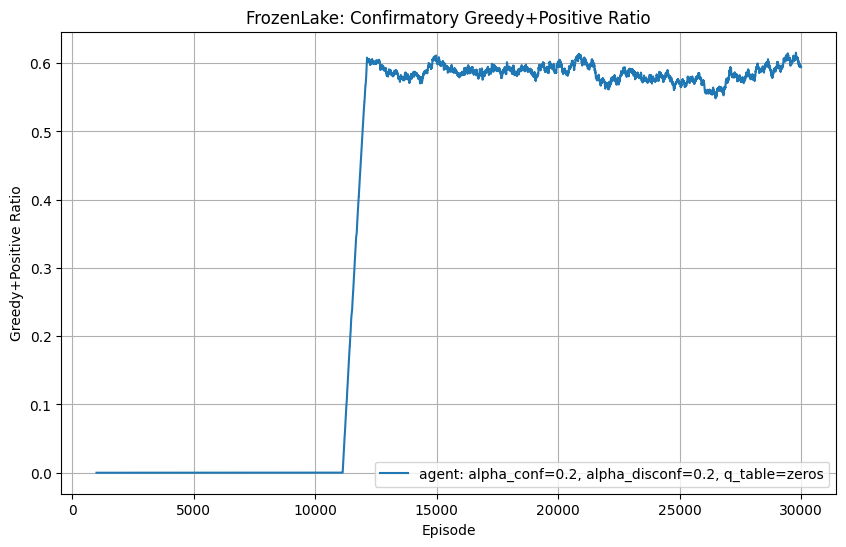

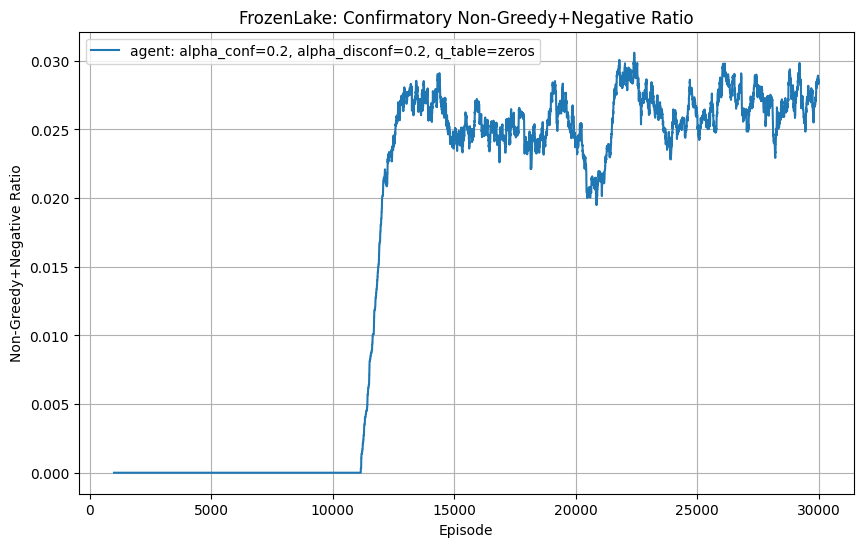

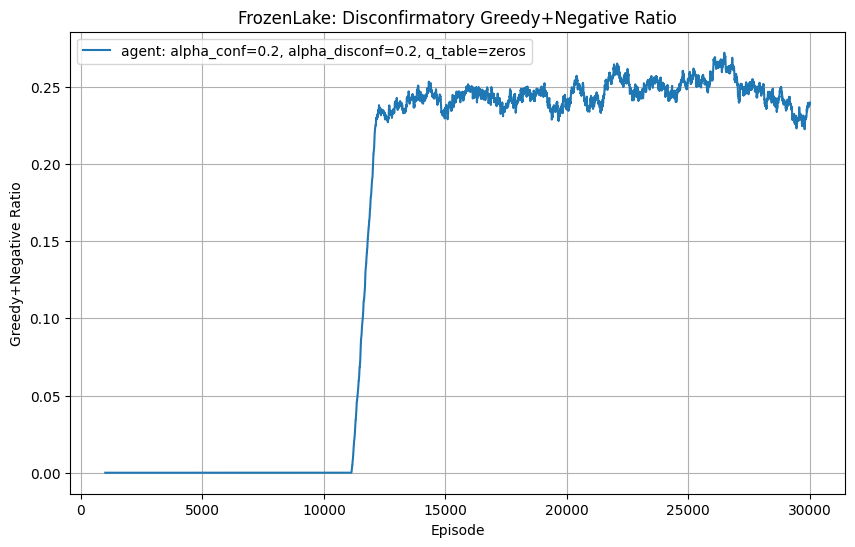

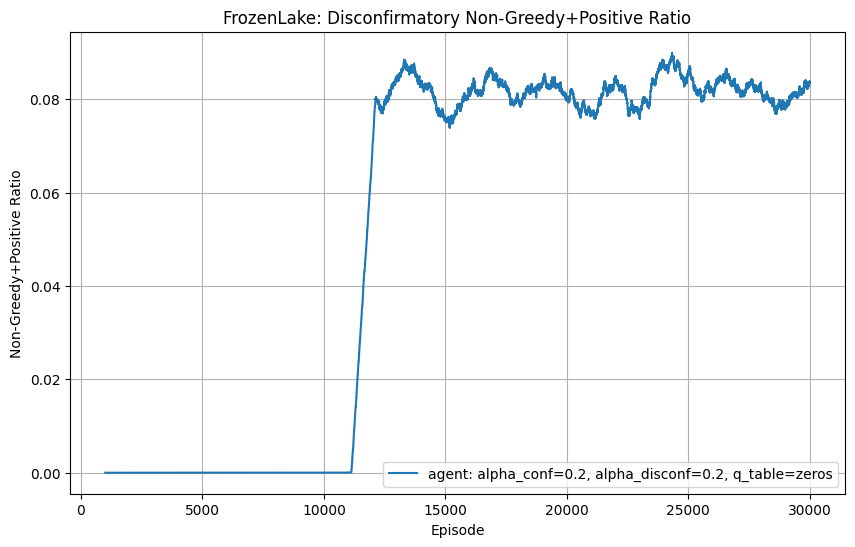

In [60]:
plot_sweep_training(
    results,
    window_size=1000,
    plot_specs=frozenlake_training_plot_specs(),
)

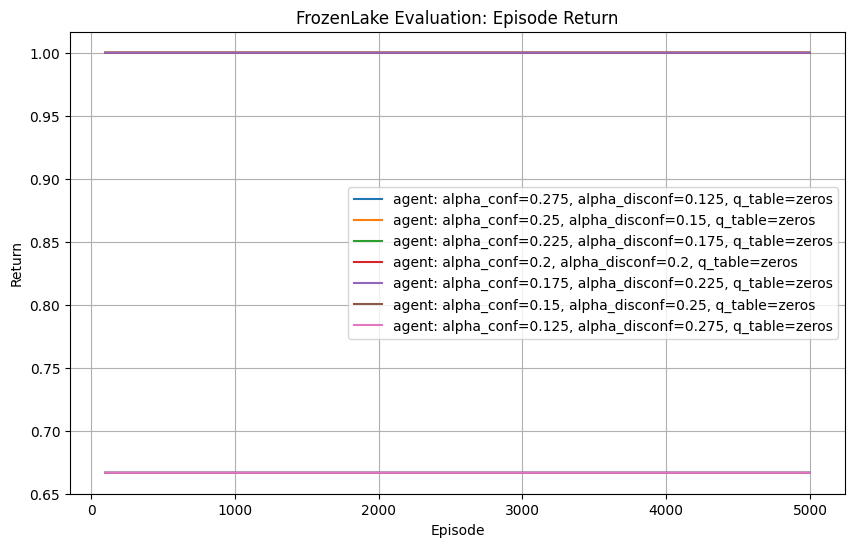

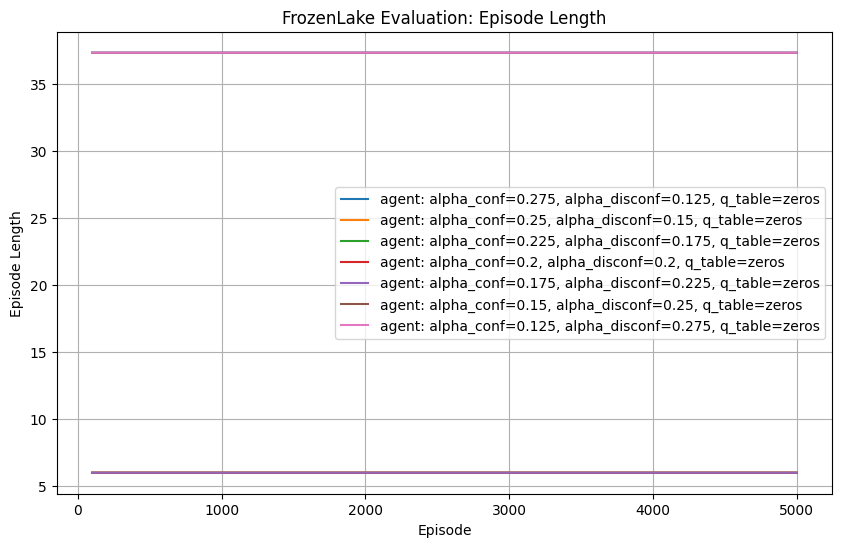

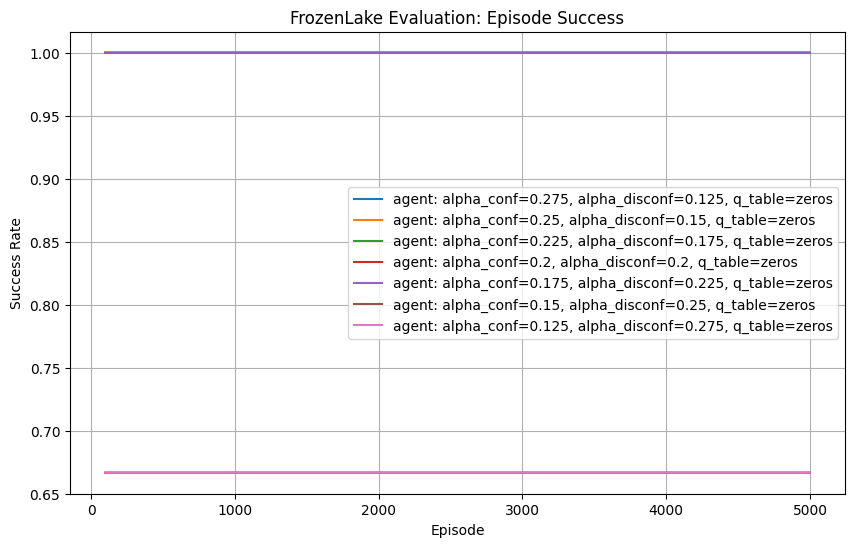

In [102]:
plot_sweep_evaluation(
    results,
    window_size=100,
    plot_specs=frozenlake_evaluation_plot_specs(),
)

In [16]:
# compare td_error vs td_error_v moving averages for one run
from plots.archive.td_error_plots import (
    plot_moving_average_td_errors_multi,
    plot_moving_average_td_errors_neg_multi,
)

run_index = 0
td_error_metrics = results[run_index]["training"]["td_error"]
td_errors = td_error_metrics.get("total_td_error_per_episode")
td_errors_v = td_error_metrics.get("total_td_error_per_episode_v")
if td_errors is None or td_errors_v is None:
    raise ValueError("Missing td_error series; check metrics keys.")

plot_moving_average_td_errors_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)
plot_moving_average_td_errors_neg_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)


ImportError: cannot import name 'plot_moving_average_td_errors_multi' from 'plots.archive.td_error_plots' (/Users/aatukallio/frustration_msc/src/plots/archive/td_error_plots.py)

## Positivity bias results

In [ ]:
# SARSA positivty bias agent
from agents.sarsa_td0_positivity_bias import (
    SarsaTD0PositivityBiasConfig,
    SarsaTD0PositivityBiasAgent,
)

In [ ]:
def asymmetric_alphas(alpha_0: float, ratio: float) -> dict:
    """Return asymmetric step-sizes with a fixed mean and ratio."""
    if alpha_0 <= 0 or ratio <= 0:
        raise ValueError("alpha_0 and ratio must be > 0")

    alpha_negative = round((2.0 * alpha_0) / (ratio + 1.0), 4)
    alpha_positive = round(
        ratio * alpha_negative, 4
    )  # same as 2*alpha_0*ratio/(ratio+1)

    return {"alpha_positive": alpha_positive, "alpha_negative": alpha_negative}

In [ ]:
## Agents
# sarsa_td0 agent
agent_factory = SarsaTD0PositivityBiasAgent
sarsa_td0_config = SarsaTD0PositivityBiasConfig(**BASE_AGENT_CONFIG)

In [ ]:
base_train = TrainingConfig(
    name="FrozenLake_sarsa_td0",
    num_train_episodes=10000,
    env_kwargs={"config": env_config},
    agent_kwargs={"config": sarsa_td0_config},
)

base_eval = EvaluateConfig(
    name="FrozenLake_sarsa_td0",
    num_eval_episodes=2000,
    env_kwargs={"config": env_config},
)

In [ ]:
# different q_tables
env = get_frozenlake_env(env_config)
num_states = env.observation_space.n
num_actions = env.action_space.n
q0 = np.zeros((num_states, num_actions), dtype=np.float64)

In [7]:
# mean alpha_0 = 0.2
a_0 = 0.2
ratios = [0.2, 0.5, 1.0, 2.0, 5.0]

seeds = list(range(5))

sweep = {
    "agent_kwargs": [
        {
            **asymmetric_alphas(a_0, r),  # gives alpha_positive / alpha_negative
            "seed": seed,
            "initial_q_table": q0,
            "initial_q_table_label": "zeros",
        }
        for r in ratios
        for seed in seeds
    ],
}

In [ ]:
results = run_sweep(
    base_training=base_train,
    base_evaluation=base_eval,
    sweep=sweep,
    env_factory=get_frozenlake_env,
    agent_factory=agent_factory,
)

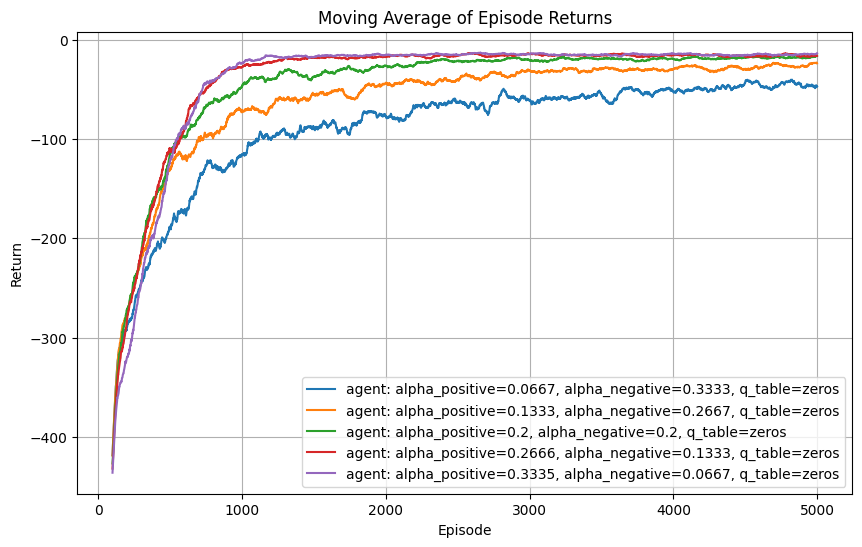

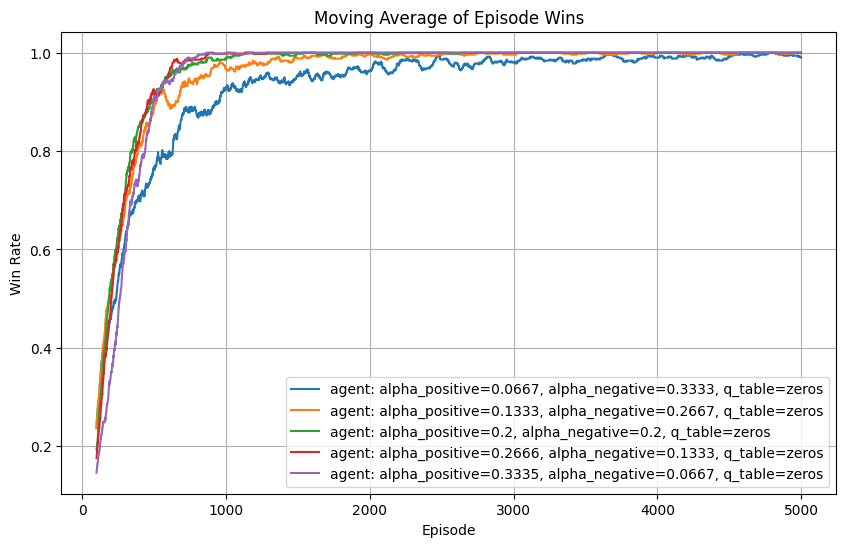

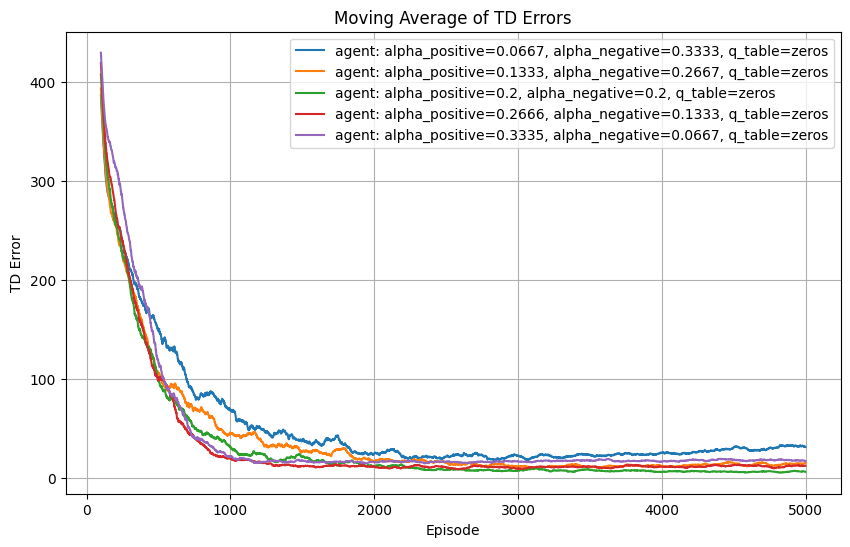

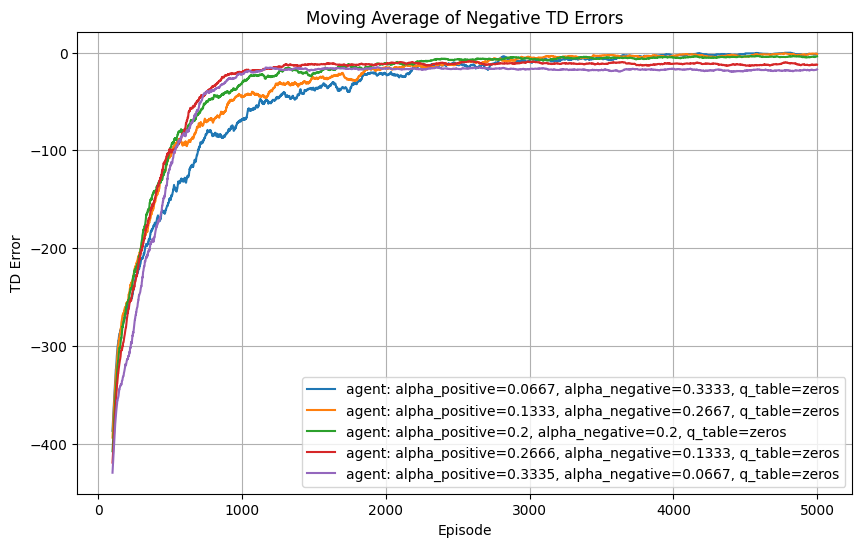

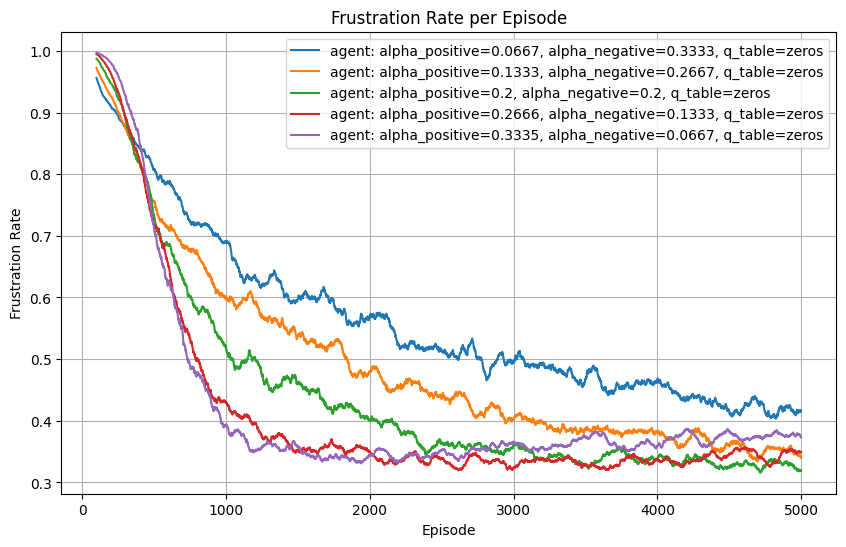

In [ ]:
plot_sweep_training(results, window_size=100, plot_specs=frozenlake_training_plot_specs())

In [ ]:
plot_sweep_evaluation(results, window_size=100, plot_specs=frozenlake_evaluation_plot_specs())

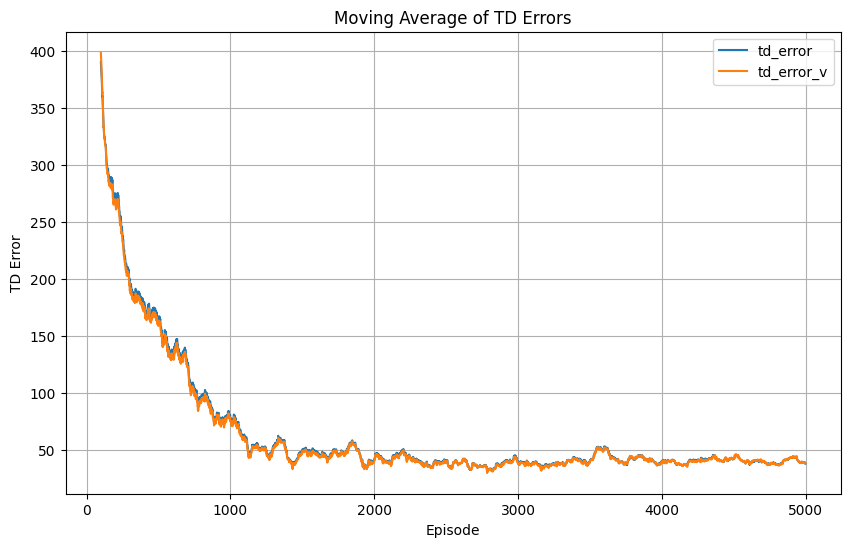

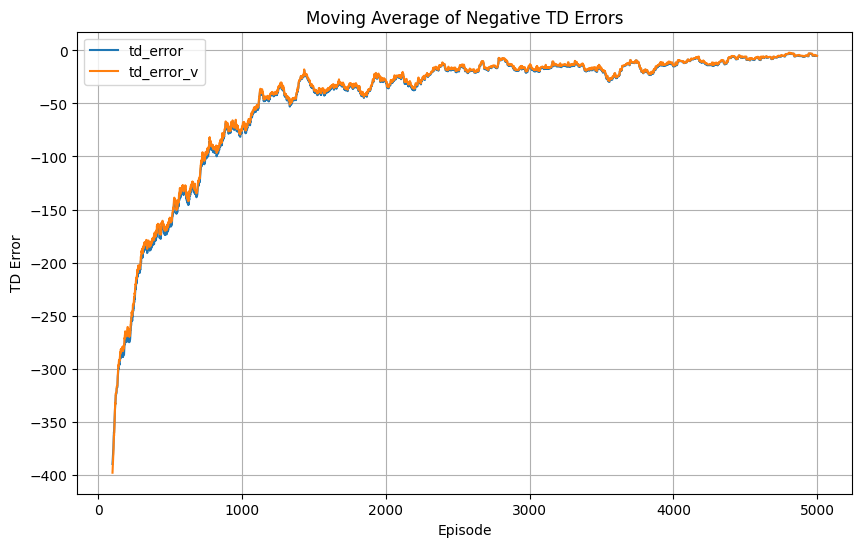

In [13]:
# compare td_error vs td_error_v moving averages for one run
from plots.td_error_plots import (
    plot_moving_average_td_errors_multi,
    plot_moving_average_td_errors_neg_multi,
)

run_index = 0
td_error_metrics = results[run_index]["training"]["td_error"]
td_errors = td_error_metrics.get("total_td_error_per_episode")
td_errors_v = td_error_metrics.get("total_td_error_per_episode_v")
if td_errors is None or td_errors_v is None:
    raise ValueError("Missing td_error series; check metrics keys.")

plot_moving_average_td_errors_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)
plot_moving_average_td_errors_neg_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)